<a href="https://colab.research.google.com/github/zfukuoka/Copying_a_sutra/blob/master/ISBN978-4-7981-6720-6/list9_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 変分オートエンコーダ（VAE）

* 9.4 VAEの実装

### リスト 9.6 訓練用データの用意

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


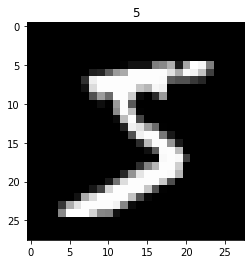

訓練用データの形状: (60000, 784) テスト用データの形状: (10000, 784)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

# 書くピクセルの値を0-1の範囲に収める
x_train = x_train / 255
x_test = x_test / 255

# 手書き文字画像を1つ表示
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

# 1次元に変換する
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("訓練用データの形状:", x_train.shape, "テスト用データの形状:", x_test.shape)

#### リスト 9.7 VAEの各設定

In [2]:
epochs = 10
batch_size = 128
n_in_out = 784
n_z = 2
n_mid = 256

### リスト 9.8 VAEのモデル構築

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import backend as K

# 潜在変数をサンプリングするための関数
def z_sample(args):
  mu, log_var = args
  epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
  return mu + epsilon * K.exp(log_var / 2)

# Encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

# Decoder
mid_decoder = Dense(n_mid, activation="relu")
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

# VAEのモデルを生成
model_vae = Model(x, y)

# 損失関数
eps = 1e-7
rec_loss = K.sum(-x * K.log(y + eps) - (1 - x) * K.log(1 - y + eps)) / batch_size
reg_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            514         ['dense[0][0]']                  
                                                                                              

### リスト 9.9 VAEの学習

In [4]:
model_vae.fit(
    x_train, x_train, shuffle=True, epochs=epochs,
    batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 10s 19ms/step - loss: 205.0701 - val_loss: 173.8820
Epoch 2/10
469/469 [==============================] - 10s 21ms/step - loss: 170.7819 - val_loss: 166.0894
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 166.5174 - val_loss: 163.5924
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 164.4551 - val_loss: 162.1177
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 162.9561 - val_loss: 160.7498
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 161.7174 - val_loss: 159.6571
Epoch 7/10
469/469 [==============================] - 6s 12ms/step - loss: 160.6261 - val_loss: 158.6198
Epoch 8/10
469/469 [==============================] - 6s 12ms/step - loss: 159.6466 - val_loss: 157.8429
Epoch 9/10
469/469 [==============================] - 6s 12ms/step - loss: 158.7728 - val_loss: 157.1814
Epoch 10/10
469/469 [==============================

### リスト 9.10 潜在空間の可視化

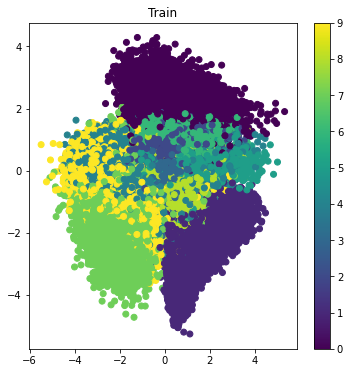

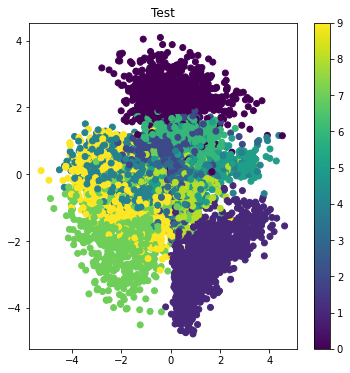

In [5]:
# 潜在変数を得るためのモデル
encoder = Model(x, z)

# 訓練データから作った潜在変数を2次元プロット
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)
# ラベルを色で表す
plt.title("Train")
plt.colorbar()
plt.show()

# テストデータを入力して潜在空間に2次元プロットする 正解ラベルを色で表示
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

### リスト 9.11 潜在変数を連続的に変化させて画像を生成

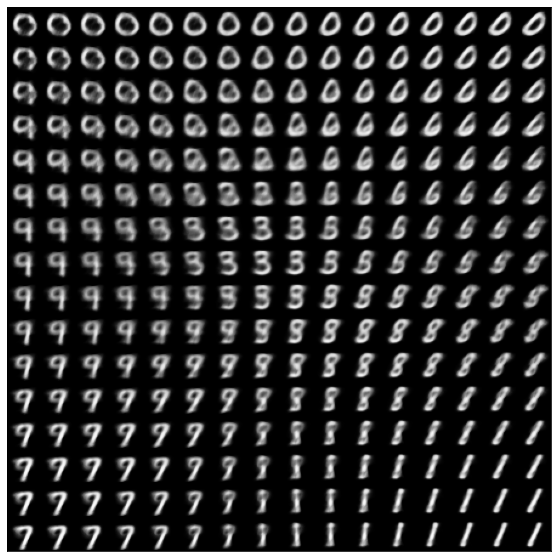

In [6]:
# 画像の生成器
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

# 画像を並べる設定
n = 16
image_size = 28
matrix_image = np.zeros((image_size * n, image_size * n))

# 潜在変数
z_1 = np.linspace(2, -2, n)
z_2 = np.linspace(-2, 2, n)


# 潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
  for j, z2 in enumerate(z_2):
    decoded = generator.predict(np.array([[z2, z1]]))
    image = decoded[0].reshape(image_size, image_size)
    matrix_image[i * image_size: (i + 1) * image_size, j * image_size: (j + 1) * image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()